In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)

2.11.0


## Preparing IMDB dataset
### Download

In [7]:
if not os.path.isdir('aclImdb'):
  url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

  dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                      untar=True, cache_dir='.',
                                      cache_subdir='')

  dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir = os.path.join(os.getcwd(), 'aclImdb')

In [8]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

### Delete unused data

In [15]:
if os.path.isfile(os.path.join(train_dir, 'unsup')):
  remove_dir = os.path.join(train_dir, 'unsup')
  shutil.rmtree(remove_dir)

### Load dataset

In [16]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, # 20% of the training set will be used for validation
    subset='training', 
    seed=seed)
print()
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)
print()
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.

Found 25000 files belonging to 2 classes.


### Preview

In [17]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

print()
print("\nLabel 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

### Prepare

In [18]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
    '[%s]' % re.escape(string.punctuation),
    '')

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [20]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [21]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [22]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized review", vectorize_text(first_review, first_label))
print("48 ---> ", vectorize_layer.get_vocabulary()[1287])
print(" 4 ---> ", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int32)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Creation

### Layers

In [25]:
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

### Loss and Optimizer for binary classification

In [26]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Training

In [27]:
checkpoint_path = "imdb_reviews_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[cp_callback])

Epoch 1/10


622/625 [============================>.] - ETA: 0s - loss: 0.6656 - binary_accuracy: 0.6909
Epoch 1: saving model to imdb_reviews_checkpoints\cp.ckpt
625/625 [==============================] - 9s 13ms/step - loss: 0.6654 - binary_accuracy: 0.6913 - val_loss: 0.6170 - val_binary_accuracy: 0.7694
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.5508 - binary_accuracy: 0.7998
Epoch 2: saving model to imdb_reviews_checkpoints\cp.ckpt
625/625 [==============================] - 2s 3ms/step - loss: 0.5508 - binary_accuracy: 0.7998 - val_loss: 0.4993 - val_binary_accuracy: 0.8208
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.4450 - binary_accuracy: 0.8450
Epoch 3: saving model to imdb_reviews_checkpoints\cp.ckpt
625/625 [==============================] - 2s 3ms/step - loss: 0.4450 - binary_accuracy: 0.8450 - val_loss: 0.4202 - val_binary_accuracy: 0.8474
Epoch 4/10
617/625 [============================>.] - ETA: 0s - loss: 0.3795 - binary_accura

## Evaluate

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)


782/782 [==============================] - 23s 29ms/step - loss: 0.3103 - binary_accuracy: 0.8729
Loss:  0.3102618455886841
Accuracy:  0.8728799819946289


In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

### Loss


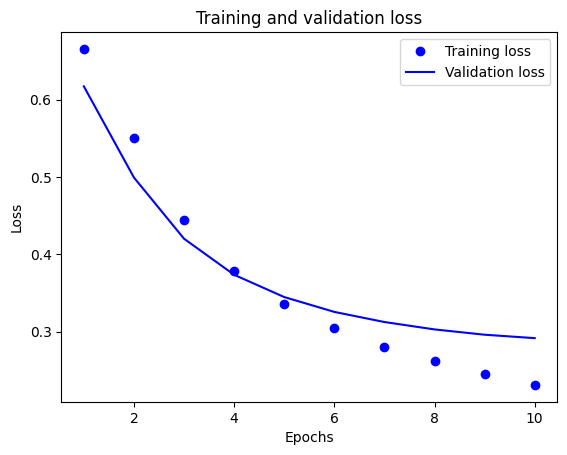

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Accuracy

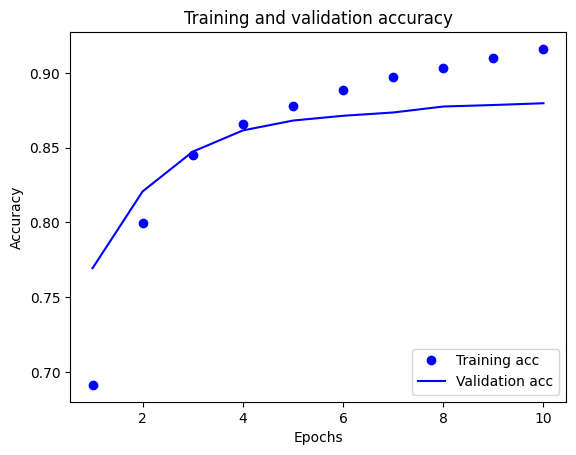

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export Model

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 4ms/step - loss: 0.3103 - accuracy: 0.8729
0.8728799819946289


In [34]:
examples = [
  "The movie was great, I really liked it!",
  "The movie was okay. Not really that great, could be better",
  "The movie was terrible...",
  "The movie was bad, I really hated it! Complete disaster"
]
# 1 = positive, 0 = negative
export_model.predict(examples)

1/1 [==============================] - 0s 240ms/step


array([[0.70342225],
       [0.4365204 ],
       [0.3433153 ],
       [0.26207262]], dtype=float32)

In [38]:
export_model.save('../models/imdb_reviews_model.tf', save_format='tf')
#export_model.save('../models/imdb_reviews_model.h5', save_format='h5')
#export_model.save('../models/imdb_reviews_model.keras')

INFO:tensorflow:Assets written to: ../models/imdb_reviews_model.tf\assets


INFO:tensorflow:Assets written to: ../models/imdb_reviews_model.tf\assets
